# 0. Import and Load

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
sns.set()

In [2]:
class KFoldCatBoostRegressor:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.kfold = KFold(n_splits=5, shuffle=True, random_state=108)
    
    def fit(self, x_train, y_train, **fit_kwargs):
        self.regressors = []
        
        for train_idx, valid_idx in self.kfold.split(x_train):
            regressor = catboost.CatBoostRegressor(**self.kwargs)

            regressor.fit(
                x_train.iloc[train_idx],
                y_train.iloc[train_idx],
                eval_set=(x_train.iloc[valid_idx], y_train.iloc[valid_idx]),
            )
            self.regressors.append(regressor)
    
    def predict(self, x):
        return sum([model.predict(x) for model in self.regressors]) / len(self.regressors)
    
    def get_feature_importance(self):
        return (
            sum(
                [col.get_feature_importance(prettified=True).set_index('Feature Id') for col in self.regressors]
            )/6
        ).sort_values('Importances')

In [3]:
with open('models/catboost.pkl', 'rb') as file:
    model = pickle.load(file)

In [4]:
with open('validation_set/set.pkl', 'rb') as file:
    df_set = pickle.load(file)

In [5]:
x_test, y_test = df_set['x_test'], df_set['y_test']
x_train, y_train = df_set['x_train'], df_set['y_train']
sample = df_set['sample']

# 1. Metrics

In [ ]:
prediction = model.predict(x_test)

In [7]:
ape = (abs(prediction-y_test) / y_test)
mape = ape.mean()

x = np.linspace(0, 1, 101)
y = ape.quantile(x).values * 100

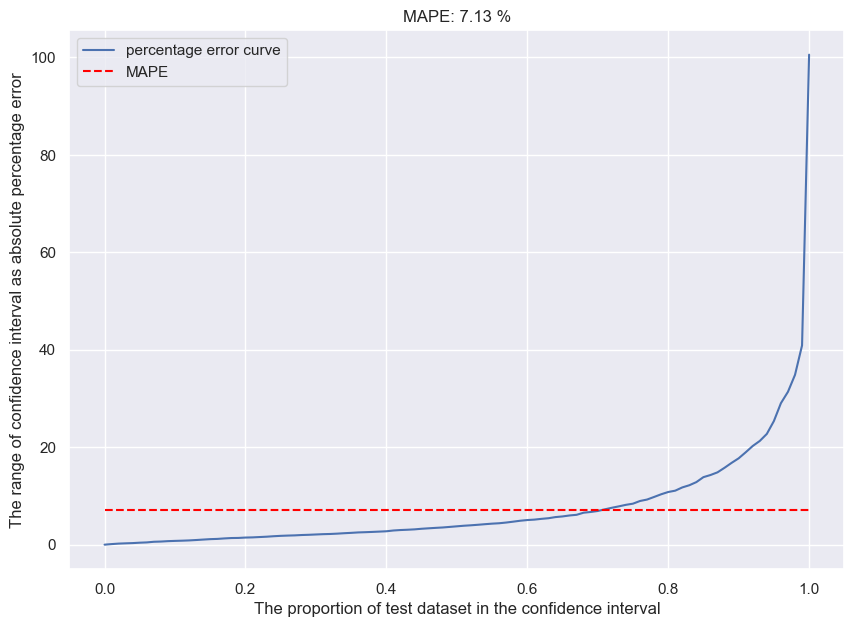

In [8]:
plt.figure(figsize=(10, 7))
plt.plot(x, y, label='percentage error curve')
plt.title(f'MAPE: {mape*100:.2f} %')
plt.xlabel('The proportion of test dataset in the confidence interval')
plt.ylabel('The range of confidence interval as absolute percentage error')
plt.hlines(mape*100, 0, 1, color='red', linestyle='--', label='MAPE')
plt.legend();

In [9]:
sape = abs(prediction - y_test) * 2 / abs(prediction + y_test)
smape = sape.mean()

x = np.linspace(0, 1, 101)
y = sape.quantile(x).values * 100

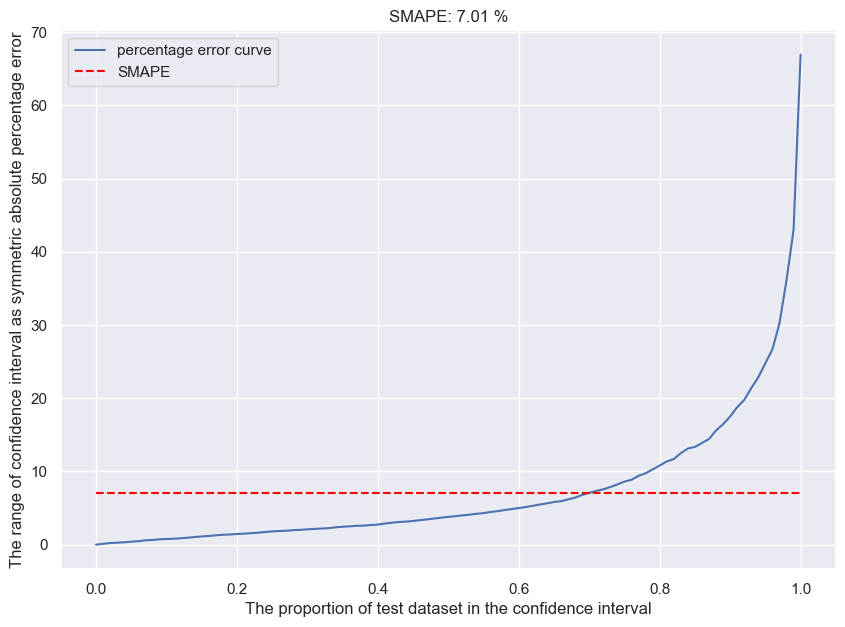

In [10]:
plt.figure(figsize=(10, 7))
plt.plot(x, y, label='percentage error curve')
plt.title(f'SMAPE: {smape*100:.2f} %')
plt.xlabel('The proportion of test dataset in the confidence interval')
plt.ylabel('The range of confidence interval as symmetric absolute percentage error')
plt.hlines(smape*100, 0, 1, color='red', linestyle='--', label='SMAPE')
plt.legend();

In [11]:
spe = ((prediction - y_test) / y_test) ** 2
rmspe = spe.mean()**0.5
x = np.linspace(0, 1, 101)
y = (spe.quantile(x).values ** 0.5) * 100

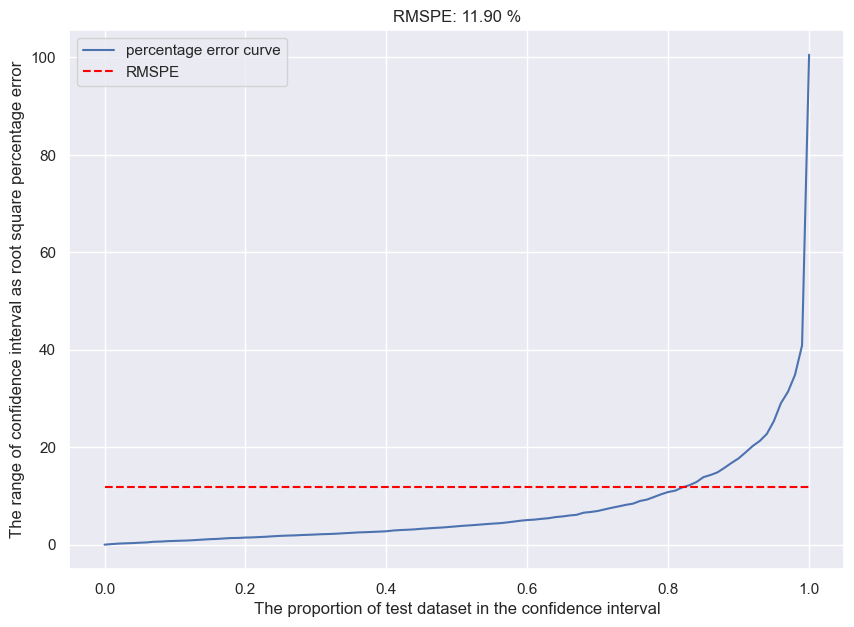

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(x, y, label='percentage error curve')
plt.title(f'RMSPE: {rmspe*100:.2f} %')
plt.xlabel('The proportion of test dataset in the confidence interval')
plt.ylabel('The range of confidence interval as root square percentage error')
plt.hlines(rmspe*100, 0, 1, color='red', linestyle='--', label='RMSPE')
plt.legend();

In [13]:
mae = abs(prediction - y_test).mean()
rmse = ((prediction - y_test) ** 2).mean() ** 0.5

mae_price = (abs(prediction - y_test) * x_test['area']).mean()
rmse_price = (((prediction - y_test) * x_test['area']) ** 2).mean() ** 0.5

In [14]:
print(f"MAE:\t{mae}")
print(f"RMSE:\t{rmse}")
print()
print(f"MAE for price:\t{mae_price}")
print(f"RMSE for price:\t{rmse_price}")

MAE:	8174.422651181218
RMSE:	14090.199939210328

MAE for price:	540455.0699733739
RMSE for price:	1372650.3276299087


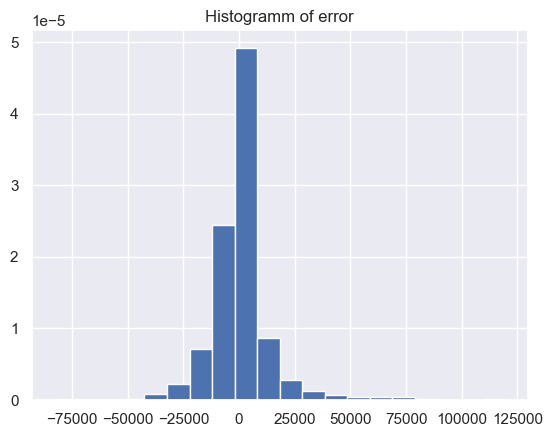

In [15]:
ax = (y_test - prediction).hist(bins=20, density=True)
ax.set_title('Histogramm of error');

In [30]:
se = (y_test - prediction)**2

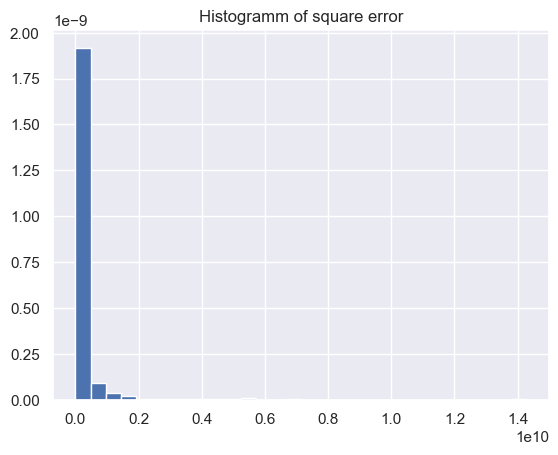

In [32]:
ax = se.hist(bins=30, density=True)
ax.set_title('Histogramm of square error');

In [16]:
dist_df = pd.DataFrame([
    *[(val, 'prediction') for val in prediction],
    *[(val, 'actual') for val in y_test],
], columns=['value', 'type'])

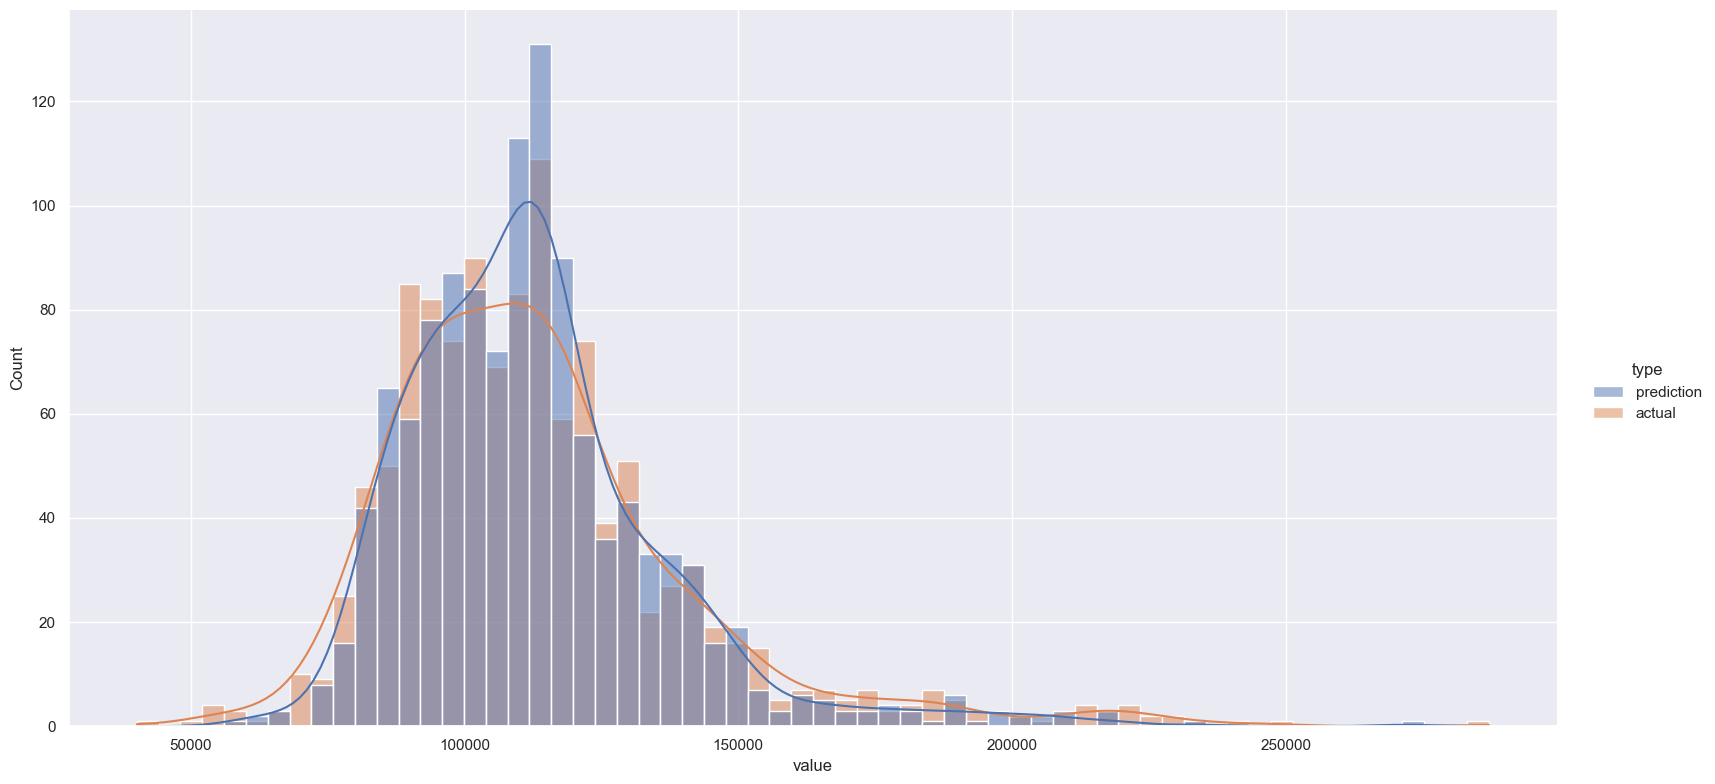

In [17]:
sns.displot(dist_df, x='value', hue='type', height=8, aspect=2, kind='hist', kde=True);

In [59]:
determanation = 1 - ((y_test - prediction)**2).sum() / ((y_test - y_test.mean()) ** 2).sum()
print(f"Determanation coefficient:\t {determanation:.4f}")

Determanation coefficient:	 0.7518


# 2. Feature analysis

In [90]:
pd.set_option('display.max_rows', 200)

In [91]:
feat_importance = model.get_feature_importance().sort_values(by='Importances', ascending=False)

In [142]:
feat_to_exclude = []
for submode in model.regressors:
    model_feat_importance = submode.get_feature_importance(prettified=True)
    feat_to_exclude.extend(model_feat_importance[model_feat_importance['Importances'] == 0]['Feature Id'].tolist())

In [144]:
set(feat_to_exclude)

{'first_dt_alarm_document_date_week',
 'first_dt_alarm_document_date_year',
 'first_dt_exclude_date_from_program_year'}

In [124]:
feat_importance

,Importances
Feature Id,
post_index,8.456738
area,6.044458
n_rooms,4.894497
floor,2.759996
school_1_id,2.716831
locator_type,2.583710
first_num_commission_year,2.528189
locator_class,2.323156
street,2.256873
